# **Pretraining and Transfer Learning**

## **Installing and Importing Libraries**

In [1]:
!pip install tensorflow

In [2]:
# array processing + math
import numpy as np
import pandas as pd
import scipy
import math

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# looping - very helpful for data manpulation scripts
from tqdm.notebook import tqdm

# deep learning staple libraries
# !pip install tensorflow # install if necessary
import sklearn
import tensorflow as tf
from tensorflow import keras

# keras specifics
import keras.layers as L
import keras.backend as K
from keras.utils.vis_utils import plot_model

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-02-20 10:59:20.581822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-20 10:59:20.581848: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## **Transfer Learning**

### **No Architecture or Weight Changes**

Retrieving and visualizing input data to ImageNet model.

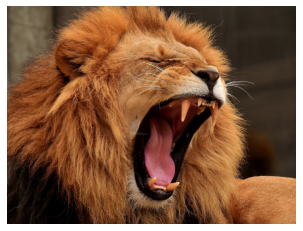

In [3]:
import PIL, requests
from PIL import Image
url = 'https://cdn.pixabay.com/photo/2018/04/13/21/24/lion-3317670_1280.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))

plt.imshow(im)  # display array
plt.axis('off') # turn off axes
plt.show()      # show figure

Create transfer learning model using InceptionV3 base model.

In [6]:
# importing relevant layers and models
from keras.layers import Input
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# defining input pipeline
input_layer = Input((None, None, 3))
reshape_layer = Resizing(299,299)(input_layer)
preprocess_layer = preprocess_input(reshape_layer)

# defining base model
inceptionv3 = InceptionV3(include_top=True, weights='imagenet')(preprocess_layer)

# create model
model = keras.models.Model(inputs=input_layer, outputs=inceptionv3)

2022-02-20 11:03:54.786213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-20 11:03:54.786261: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-20 11:03:54.786304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-61e195dae136b0d2eea966b8): /proc/driver/nvidia/version does not exist
2022-02-20 11:03:54.786585: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


96124928/96112376 [==============================] - 2s 0us/step


Predict on input image and decode.

In [7]:
from keras.applications.inception_v3 import decode_predictions
reshaped_im = np.array([im])
decode_predictions(model.predict(reshaped_im))

49152/35363 [=========================================] - 0s 0us/step


[[('n02129165', 'lion', 0.90916604),
  ('n02112137', 'chow', 0.00884418),
  ('n02130308', 'cheetah', 0.0023307255),
  ('n04328186', 'stopwatch', 0.0010145266),
  ('n02106030', 'collie', 0.0008584279)]]

### **Transfer Learning Without Layer Freezing**

Define the transfer learning model.

87924736/87910968 [==============================] - 2s 0us/step


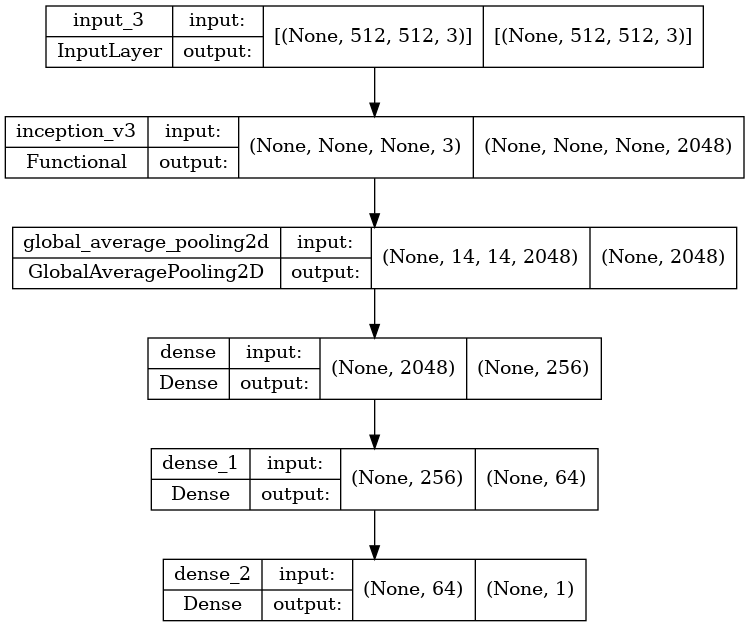

In [8]:
# importing relevant layers and models
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3

# building model
input_layer = Input((512,512,3))
inceptionv3 = InceptionV3(include_top=False,
                          weights='imagenet')(input_layer)
pooling = GlobalAveragePooling2D()(inceptionv3)
custom_dense_1 = Dense(256, activation='relu')(pooling)
custom_dense_2 = Dense(64, activation='relu')(custom_dense_1)
output_layer = Dense(1, activation='sigmoid')(custom_dense_2)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# plot model
plot_model(model, show_shapes=True)

### **Transfer Learning With Layer Freezing**

Create transfer learning model.

In [9]:
# instantiate inception base model
inception_model = InceptionV3(include_top=False, weights='imagenet')

# build transfer learning model
input_layer = Input((512,512,3))
inceptionv3 = inception_model(input_layer)
pooling = GlobalAveragePooling2D()(inceptionv3)
custom_dense_1 = Dense(256, activation='relu')(pooling)
custom_dense_2 = Dense(64, activation='relu')(custom_dense_1)
output_layer = Dense(1, activation='sigmoid')(custom_dense_2)
model = keras.models.Model(inputs=input_layer, outputs=output_layer)

# view trainable and untrainable parameter counts
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                           

Freeze base model and view effect on trainable vs non-trainable parameters.

In [10]:
# freeze inception model weights
inception_model.trainable = False

# view trainable and untrainable parameter counts
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                           